In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from functools import partial
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from scipy.linalg import LinAlgWarning
import warnings

# glmnet packages
from glmnet import ElasticNet

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=LinAlgWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

In [3]:
df = pd.read_csv("/Users/pedro.hcardoso/dev/book/marketing-book/datasets/weekly_ad_spend.csv")

In [4]:
df

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2754371.66667,67075.04000,0.00000,38185.46667,72903852.71259,0.00000,0,8125009,22821.39874,na,19401.65385
1,2015-11-30,2584276.66667,85840.36000,0.00000,0.00000,16581099.54533,29511.71546,12400,7901549,3425.85735,na,14791.00000
2,2015-12-07,2547386.66667,0.00000,396835.20000,1361.60000,49954773.67047,36132.35896,11360,8300197,12769.12613,na,14544.00000
3,2015-12-14,2875220.00000,250350.92000,0.00000,53040.00000,31649297.02879,36804.21096,12760,8122883,8401.47203,na,2800.00000
4,2015-12-21,2215953.33333,0.00000,832008.00000,0.00000,8802269.47875,28401.74407,10840,7105985,2068.74782,na,15478.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,96692.80000,61489.46667,0.00000,152840.32341,44840,7612762,0.00000,na,28157.00000
204,2019-10-21,2182825.00000,61967.04000,0.00000,0.00000,56881962.23521,103680.04782,41480,6701667,13362.45755,na,10644.00000
205,2019-10-28,2377706.66667,8793.00000,22550.40000,6990.40000,0.00000,138387.70414,45880,7688920,0.00000,na,9597.00000
206,2019-11-04,2732825.00000,8981.20000,0.00000,9620.53333,0.00000,151707.99046,53640,8815710,0.00000,na,90189.00000


In [5]:
def adstock_transform(x, retention_rate, duration=13, peak_delay=None, method='geometric'):
    
    x_adstock = np.zeros_like(x)
    
    if method == 'convolution':
        if peak_delay:
            weights = [retention_rate**((w-peak_delay)**2) for w in range(0, duration)]
        else:
            weights = [retention_rate**w for w in range(0, duration)]

        x_adstock = x.rolling(duration, min_periods=1).apply(lambda x: np.average(x[::-1], weights=weights[:len(x)]))
        
    if method == 'geometric':
        x_adstock = x + x.shift(1).fillna(0)*retention_rate
        
    return x_adstock

def hill_transform(x, slope, inflexion):
    
    inflexion = np.dot((np.min(x), np.max(x)), (1- inflexion, inflexion)) # linear interpolation/extrapolation by dot product
    x_hill = x**slope / (x**slope + inflexion**slope)
    return x_hill

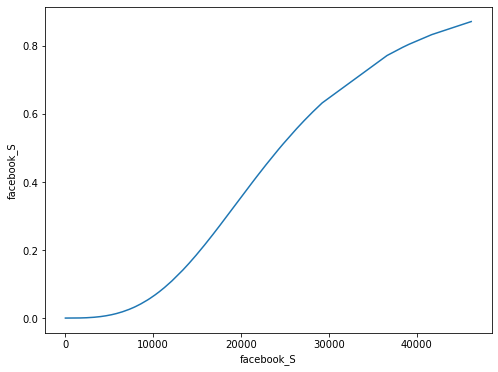

In [6]:
x = df['facebook_S']
x_decayed = np.zeros_like(x)
x_decayed[0] = x[0]
x_adstock = adstock_transform(x, 0.38)
x_hill = hill_transform(x_adstock, 3.0028976949766872, 0.5279674468947023)
plt.subplots(figsize=(8,6))
sns.lineplot(x=x_adstock, y=x_hill)
plt.show()

In [7]:
control_features = ['competitor_sales_B', 'newsletter', 'search_clicks_P', 'facebook_I'] # 'events']
target_feature = 'revenue'
spend_features = ['tv_S', 'ooh_S', 'print_S', 'search_S', 'facebook_S']

train_test_split_fraction = (.33, .5)

model_params ={'alpha': (0.01, 1000)}

feature_params = {'tv_S': 
                       {'adstock_params': {'retention_rate': (0.3, 0.7), 'duration': (1, 15), 'peak_delay': (0, 4), 'method': 'convolution'},
                        'hill_params': {'slope': (.1, 3), 'inflexion': (.1, 1)}},
                   'ooh_S': 
                       {'adstock_params': {'retention_rate': (0.3, 0.7), 'duration': (1, 15), 'peak_delay': (0, 4), 'method': 'convolution'},
                        'hill_params': {'slope': (.1, 3), 'inflexion': (.1, 1)}},
                   'print_S': 
                       {'adstock_params': {'retention_rate': (0.3, 0.7), 'duration': (1, 15), 'peak_delay': (0, 4), 'method': 'convolution'},
                        'hill_params': {'slope': (.1, 3), 'inflexion': (.1, 1)}},
                   'search_S': 
                       {'adstock_params': {'retention_rate': (0.1, 0.3), 'method': 'geometric'},
                        'hill_params': {'slope': (.1, 3), 'inflexion': (.1, 1)}},
                   'facebook_S': 
                       {'adstock_params': {'retention_rate': (0.1, 0.3), 'method': 'geometric'},
                        'hill_params': {'slope': (.1, 3), 'inflexion': (.1, 1)}}
                  }

In [8]:
np.array([100], ndmin=1).shape

(1,)

In [9]:
lower_limits = [0, 0, 0, 0, 0, -np.inf, 0, 0, 0]
upper_limits = [np.inf, np.inf, np.inf, np.inf, np.inf, 0, np.inf, np.inf, np.inf]

model = ElasticNet(alpha=0, lower_limits=lower_limits, upper_limits=upper_limits, n_splits=0, lambda_path=[0, 100])
model.fit(df[spend_features + control_features], df[target_feature])
model.predict(df[spend_features + control_features], lamb=[100])

array([     1986296.202,      1640716.204,      1722582.270,      2346792.577,      1669338.270,      2359574.291,
            1879007.688,      1990588.179,      1540653.244,      1640871.383,      1431490.863,      1532139.372,
            1832290.592,      1198075.145,      1634432.430,      1493793.456,      1411531.834,      1220984.247,
            1882636.039,      1218392.490,      1242585.854,      1445001.815,      1191252.462,      1345668.903,
            1198012.833,      1403952.442,      1330893.829,      1188870.868,      1150646.544,      1184675.058,
            1589271.452,      1158642.329,      1329402.325,      1210610.383,      1800112.576,      1247958.125,
            1930976.830,      1309211.882,      1478104.916,      1440194.378,      1580527.832,      1540679.985,
            1464491.179,      1989425.808,      1394409.937,      2892895.749,      1770172.294,      2378950.993,
            2007162.078,      2474568.367,      2165209.915,      1904901.037,  

In [10]:
model.lambda_path_

array([           0.000,          100.000])

In [27]:
def optuna_trial(trial, df, control_features, target_feature, spend_features, train_test_split_fraction, feature_params, model_params):
    
    ridge_alpha = trial.suggest_float('rigde_alpha', model_params['alpha'][0], model_params['alpha'][1])
    split_fraction = trial.suggest_float('train_test_split_fraction', train_test_split_fraction[0], train_test_split_fraction[1])
    spend_features_hill = []
    
    for feature in spend_features:
        retention_rate = trial.suggest_float(f'{feature}_retention_rate',
                                             feature_params[feature]['adstock_params']['retention_rate'][0],
                                             feature_params[feature]['adstock_params']['retention_rate'][1])
        
        if 'duration' in feature_params[feature]['adstock_params'].keys():
            duration = trial.suggest_int(f'{feature}_duration',
                                           feature_params[feature]['adstock_params']['duration'][0],
                                           feature_params[feature]['adstock_params']['duration'][1])
        else:
            duration=None
        
        if 'peak_delay' in feature_params[feature]['adstock_params'].keys():
            peak_delay = trial.suggest_int(f'{feature}_peak_delay',
                                           feature_params[feature]['adstock_params']['peak_delay'][0],
                                           feature_params[feature]['adstock_params']['peak_delay'][1])
        else:
            peak_delay = None
            
        method = feature_params[feature]['adstock_params']['method']
        
        slope = trial.suggest_float(f'{feature}_slope',
                                    feature_params[feature]['hill_params']['slope'][0],
                                    feature_params[feature]['hill_params']['slope'][1])
        
        inflexion = trial.suggest_float(f'{feature}_inflexion',
                                        feature_params[feature]['hill_params']['inflexion'][0],
                                        feature_params[feature]['hill_params']['inflexion'][1])
        
        df[f'{feature}_adstocked'] = adstock_transform(df[feature], retention_rate, duration, peak_delay, method)
        df[f'{feature}_hill'] = hill_transform(df[f'{feature}_adstocked'], slope, inflexion)
        spend_features_hill.append(f'{feature}_hill')
        
    
    lower_limits = [0, 0, 0, 0, 0, -np.inf, 0, 0, 0]
    upper_limits = [np.inf, np.inf, np.inf, np.inf, np.inf, 0, np.inf, np.inf, np.inf]
    features = spend_features_hill + control_features
    
    split_point = int(df.shape[0]*split_fraction)
    
    model = ElasticNet(alpha=0, lower_limits=lower_limits, upper_limits=upper_limits, n_splits=0, lambda_path=[0, ridge_alpha])
    model.fit(df[features].iloc[:split_point], df[target_feature].iloc[:split_point].values)
    
    y_hat = model.predict(df[features].iloc[split_point:].values, lamb=[ridge_alpha])
    score = mean_absolute_error(df[target_feature].iloc[split_point:].values, y_hat)
    
    return score
    # cross_validator = TimeSeriesSplit(n_splits=2, test_size=int(df.shape[0]*split_fraction))
    # estimator = Ridge(alpha=ridge_alpha)
    
    # scores = cross_validate(estimator=estimator, X=df[features], y=df[target_feature], cv=cross_validator, scoring='neg_mean_absolute_error')
    
    #return np.mean(scores['test_score'])

objective = partial(optuna_trial,
                    df = df,
                    control_features = control_features,
                    target_feature = target_feature,
                    spend_features = spend_features,
                    train_test_split_fraction = train_test_split_fraction,
                    feature_params = feature_params,
                    model_params = model_params)

In [28]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [29]:
study.best_params

{'rigde_alpha': 834.783772481565,
 'train_test_split_fraction': 0.4156087190832473,
 'tv_S_retention_rate': 0.681407542665784,
 'tv_S_duration': 14,
 'tv_S_peak_delay': 0,
 'tv_S_slope': 2.1768281281123834,
 'tv_S_inflexion': 0.16849239854394926,
 'ooh_S_retention_rate': 0.3747089467853843,
 'ooh_S_duration': 6,
 'ooh_S_peak_delay': 2,
 'ooh_S_slope': 0.23156573699080876,
 'ooh_S_inflexion': 0.2611945030020213,
 'print_S_retention_rate': 0.6649317087441914,
 'print_S_duration': 14,
 'print_S_peak_delay': 4,
 'print_S_slope': 2.2969870039440137,
 'print_S_inflexion': 0.5322286103844153,
 'search_S_retention_rate': 0.11118541067444904,
 'search_S_slope': 0.902702206942487,
 'search_S_inflexion': 0.6343758344703544,
 'facebook_S_retention_rate': 0.2634970360775944,
 'facebook_S_slope': 1.0099992823242896,
 'facebook_S_inflexion': 0.4559299359754699}

In [30]:
study.best_value

316293.5651671939

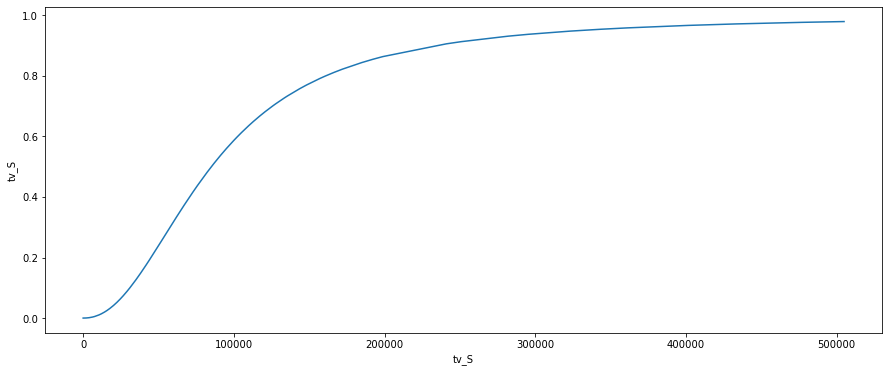

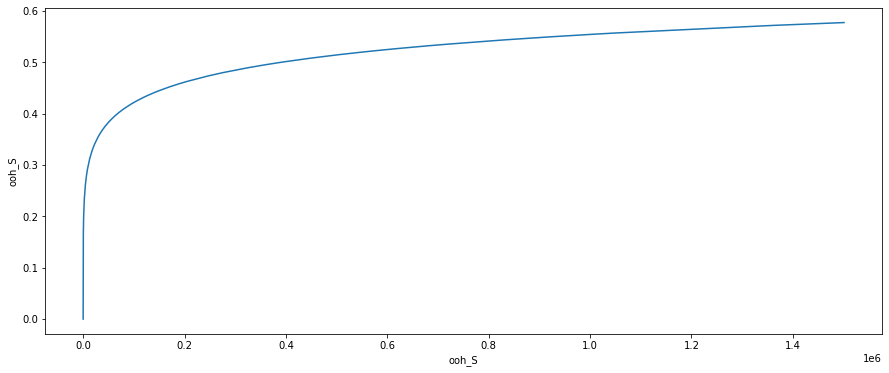

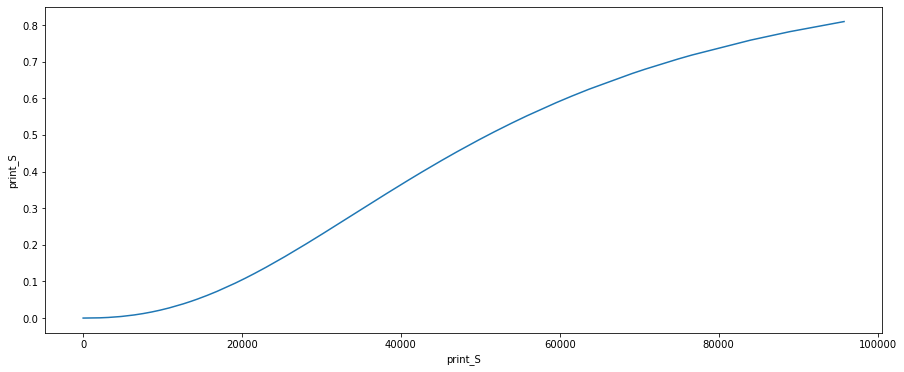

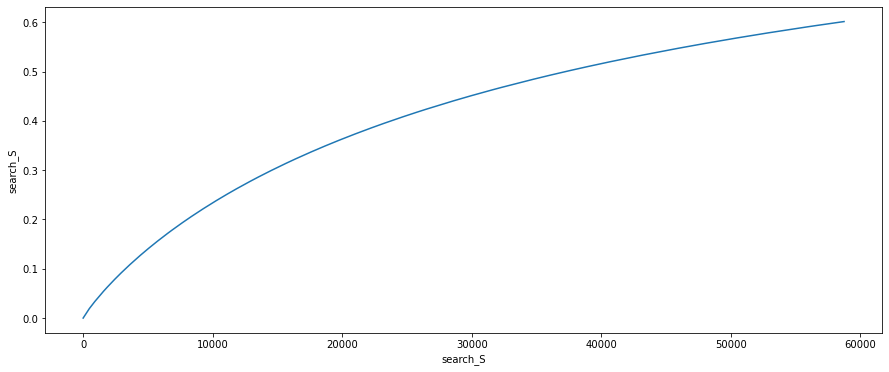

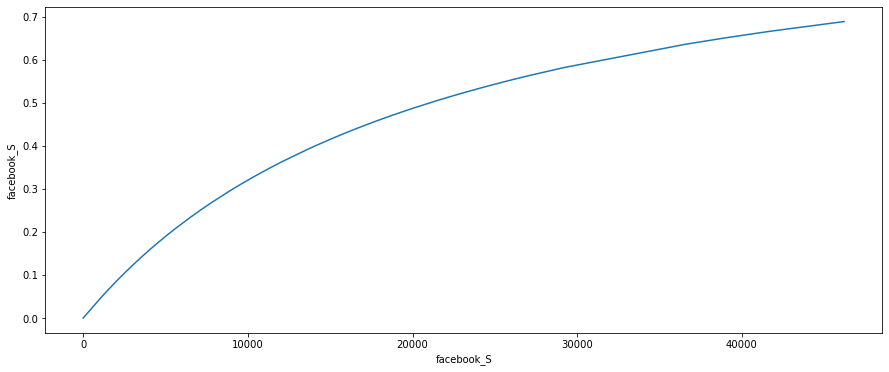

In [31]:
for feature in spend_features:
    x = df[feature]
    x_adstock = adstock_transform(x, study.best_params[f'{feature}_retention_rate'])
    x_hill = hill_transform(x_adstock, study.best_params[f'{feature}_slope'], study.best_params[f'{feature}_inflexion'])
    plt.subplots(figsize=(15,6))
    sns.lineplot(x=x_adstock, y=x_hill)
    plt.show()

In [32]:
spend_features_hill = []

for feature in spend_features:
    x = df[feature]
    x_adstock = adstock_transform(x, study.best_params[f'{feature}_retention_rate'])
    x_hill = hill_transform(x_adstock, study.best_params[f'{feature}_slope'], study.best_params[f'{feature}_inflexion'])
    df[f'{feature}_hill'] = x_hill
    spend_features_hill.append(f'{feature}_hill')

In [33]:
rigde_alpha = study.best_params['rigde_alpha']
features = spend_features_hill + control_features


model = ElasticNet(alpha=0, lower_limits=lower_limits, upper_limits=upper_limits, n_splits=0, lambda_path=[0, rigde_alpha])
model.fit(df[features], df[target_feature])

ElasticNet(alpha=0, lambda_path=[0, 834.783772481565],
           lower_limits=array([           0.000,            0.000,            0.000,            0.000,            0.000,             -inf,
                  0.000,            0.000,            0.000]),
           n_splits=0,
           upper_limits=array([             inf,              inf,              inf,              inf,              inf,            0.000,
                    inf,              inf,              inf]))

In [34]:
y_hat = model.predict(df[features], lamb=[rigde_alpha])
score = mean_absolute_percentage_error(df[target_feature], y_hat)
score

0.2419466868117651

In [35]:
pd.DataFrame.from_dict({'feature':pd.Series(features), 'coef': pd.Series(model.coef_path_[:,1])})

,feature,coef
0,tv_S_hill,873601.47505
1,ooh_S_hill,398224.33793
2,print_S_hill,350924.63862
3,search_S_hill,0.00000
4,facebook_S_hill,1137553.08328
5,competitor_sales_B,0.00000
6,newsletter,6.17540
7,search_clicks_P,4.14629
8,facebook_I,0.00000


In [36]:
df['y_hat'] = y_hat

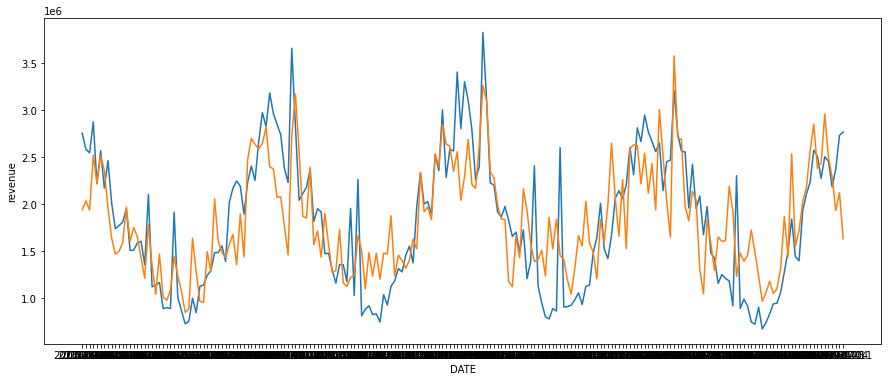

In [37]:
plt.subplots(figsize=(15, 6))
sns.lineplot(data=df, x='DATE', y='revenue')
sns.lineplot(data=df, x='DATE', y='y_hat')
plt.show()